## Exploring the NLTK / TextBlob modules on tweets about Apple, days after the infamous airpods keynote

Twitter's API (and the tweepy module) makes it pretty easy to capture tweets streaming in real time about a given search term of topic. We'll define a term, "listen" to a given number of tweets containing the term, and analyze what people are saying through the NLTK and TextBlob packages.

Credit for most of this code goes to O'Reilly's Mining the Social Web, and the specific iPython Notebook on this topic can be found here: http://nbviewer.jupyter.org/github/ptwobrussell/Mining-the-Social-Web-2nd-Edition/blob/master/ipynb/__Understanding%20the%20Reaction%20to%20Amazon%20Prime%20Air.ipynb

Where the author used more advanced or well designed Python code, I've tried to simplify it down to something I would have done myself, and not copied.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import tweepy
import seaborn as sns

Don't worry, these keys are for a special account I made for this purpose. Or are they?

In [148]:
#Define consumer keys (don't share these!)

consumer_key = 'YO2DGgw4Y7fiOQ5QqglG98z6R'
consumer_secret = '8KLklsRUYSn7YYeFp1uxNb3AVFocH4Yp8ixFJzcTk8T7Mr5Gjb'
oauth_token = '637197054-S7blHnW3kx8P6VUYgane3OYMtHaUQhwvEzRosr3i'
oauth_token_secret = 'yRN2GrKLB40SMZLWAkSkCU2Y8SggJm7oUe44P0NCrP87E'

In [149]:
#Initializing the API

auth = tweepy.OAuthHandler(consumer_key=consumer_key, consumer_secret=consumer_secret)
auth.set_access_token(oauth_token, oauth_token_secret)
api = tweepy.API(auth)
print api

We'll start with creating an empty csv file with our desired fields, to write into. We can run this block any time we want to reset the results.

In [150]:
with open('streamed_tweets.csv', 'wb') as f:
    writer = csv.writer(f)
    writer.writerow(['author_name', 'author_desc', 'tweet','language'])

Now we'll define the stream listener class, or what will actually be grabbing our tweets. We'll also put a counter in to make sure that it stops listening once it reaches the max amount of tweets we want.

In [151]:
#Create the stream listener class

class MyStreamListener(tweepy.StreamListener):
    
    #Set collection limit (http://stackoverflow.com/questions/20863486/tweepy-streaming-stop-collecting-tweets-at-x-amount)
    
    def __init__(self):
        super(MyStreamListener, self).__init__()
        self.number_of_tweets = 0
        
    def on_status(self,status):
        
        try:

            with open('streamed_tweets.csv', 'ab') as f:
                writer = csv.writer(f)
                writer.writerow([status.author.name, status.author.description, status.text, status.lang])
                self.number_of_tweets += 1

            if self.number_of_tweets <= max_tweets:
                return True
            else:
                return False
            
        #When moving from a CSV to a dataframe (later), Python has encoding errors for unusual characters.    
            
        except UnicodeEncodeError:
            pass
        
    #Disconnect stream on 420 error    
        
    def on_error(self, status_code):
        if status_code == 420:
            return False 

With the class defined, we can set our query (q), max number of tweets (max_tweets), and initialize and instance of the listener.

In [152]:
#Initialize instance of the class

q = 'apple'
max_tweets = 1000

myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = api.auth, listener = myStreamListener)
myStream.filter(track=[q])

In [53]:
#Read CSV into Pandas dataframe

df = pd.read_csv('streamed_tweets.csv')

#Create new array with only english tweets

tweets = df[df['language'] == 'en'].pop('tweet')

Now that we have our data, it's time to start looking at it. Before we get into NLTK, we'll separate all of the words in the tweets we collected and order them by how common they are.

In [54]:
#Create a list of all of the words in the tweets

tokens = []
for text in tweets.values:
    for t in text.split():
        tokens.append(t.lower().strip(":.,"))

In [55]:
#Use the counter package to find the most common words

from collections import Counter

tokens_counter = Counter(tokens)
tokens_counter.most_common(10)

[('apple', 681),
 ('i', 476),
 ('to', 334),
 ('the', 311),
 ('on', 276),
 ('a', 275),
 ('that', 234),
 ('rt', 228),
 ('my', 226),
 ('u', 215)]

Now let's get started with NLTK!

In [56]:
#Import module

import nltk

The first thing we need to do is get rid of what NLTK calls "stopwords" – things like "and" and "the".

In [57]:
nltk.download('stopwords')

for t in nltk.corpus.stopwords.words('english'):
    if t in tokens_counter:
        tokens_counter.pop(t)
        
tokens_counter.most_common(10)        

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Justin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('apple', 681),
 ('rt', 228),
 ('u', 215),
 ('-', 207),
 ('app', 205),
 ("it's", 201),
 ('ios', 151),
 ('new', 116),
 ('7', 112),
 ('iphone', 111)]

Let's try to put some of these words together and find some phrases across these tweets. From the NLTK website, collocations are "expressions of multiple words which commonly co-occur."

In [58]:
nltk_text = nltk.Text(tokens)
nltk_text.collocations()

app it's; it's called; it's known; "my training"; ever top; never
ever; could never; iconic ios; free app; new app; ios app; idc apple;
called "mytraining"; apple store; called mytraining; called "my; apple
could; #applications #itunes; lasts forever; @femalepains idc


Let's check out the context of some of these phrases using NLTK's concordance function.

In [59]:
nltk_text.concordance('ios')
print 
nltk_text.concordance('saw')

Displaying 25 of 151 matches:
out lover so i invite you to check my ios app it's known as mytraining on apple
apple could never ever top the iconic ios 7 update https://t.co/ilmeppkec7 rt @
xercise fan so i invite you to see my ios app it's called mytraining on apple h
ing enthusiast so i ask u to check my ios app it's called mytraining on apple h
n apple store https://t.co/bexjhz0m97 ios 10 features 10 exciting changes comin
nyjwqal all these new features on the ios 10 update yet u still can't add a "cl
apple could never ever top the iconic ios 7 update https://t.co/wydzivfiws rt @
apple could never ever top the iconic ios 7 update https://t.co/hqkc3mynzf rt @
apple could never ever top the iconic ios 7 update https://t.co/js8pzkrzcm spot
t.co/wx1bmztfjs #applications #itunes ios 10 seriously sucks let's get it toget
m enthusiast so i suggest u to see my ios app it's called "mytraining" on apple
 health fan so i suggest u to test my ios app it's called mytraining on apple h
 a fitness

Hm... there seems to be one perpetrator that's tweet spamming this whole joint about his/her darn fitness app. Let's figure out who it is.

In [60]:
authors = df.groupby('author_name').size()
authors.head()

author_name
#GRASSMONEY           1
#HotDeal              1
#MillionHitsSecret    1
#PleaseReTweetTHIS    1
#Solidarity101        1
dtype: int64

Hm again... no authors with more than one tweet. But it's clearly the same tweet over and over again, so what's going on? Let's make a search for the tweet and gather the usernames.

In [61]:
#Set up query and execute search

query = 'mytraining'
max_tweets = 100

search_results = api.search(q=query, count=max_tweets)

NameError: name 'api' is not defined

In [ ]:
#Extract list of users

user_counts = {}

for result in search_results:
    if result.author.screen_name not in user_counts:
        user_counts[result.author.screen_name] = 1
    else:
        user_counts[result.author.screen_name] += 1

user_counts

AHA!!! So some sort of bot has been creating Twitter accounts related to buzzwords like fitness, gym, and workout, to promote their app. Looks like we found our culprit – the reason why they didn't appear under the same username is because they're all slightly different, even though they're coming from the same place (and tweeting the same stuff).

Twitter – if you're listening, let's fix this!

Now aside from whoever this clown is, what are the accounts that are being mentioned the most in these tweets about apple?

In [62]:
#Make a list of the top accounts

accounts = []

for text in tweets:
    for t in text.split():
        if t.startswith("@"):
            accounts.append(t)
            
accounts_counter = Counter(accounts)          
accounts_counter.most_common(10)

[('@Apple', 43),
 ('@FemalePains:', 18),
 ('@FreddyAmazin:', 10),
 ('@DisickReactions:', 8),
 ('@AppleSupport', 8),
 ('@_SydWrites:', 8),
 ('@Manstagram_:', 6),
 ('@NathanZed:', 6),
 ('@puppymnkey:', 5),
 ('@SoDamnTrue:', 5)]

Not surprising – Apple itself is at the top, followed by @FemalePains. Let's see what the content of that popular tweet is.

In [63]:
female_pains = []

for text in tweets:
    if '@FemalePains' in text:
        female_pains.append(text)
        
female_pains    

['RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8azo5XCF9',
 'RT @FemalePains: idc, Apple could never ever top the iconic iOS 7 update https://t.co/D8a

I would tend to agree with that – iOS 7 was a pretty awesome update.

### Let's play around with some of the NLTK token / tagging functionality.

#### First – how verbose are our tweets – how many are one sentence, and how many are more than one sentence?

In [64]:
#Import tokenize sentence module

from nltk.tokenize import sent_tokenize

sentence_list = []

for text in tweets:
    sentence = sent_tokenize(text)
    sentence_list.append(sentence)

We can make a histogram depicting what proportion of tweets have more than one sentence.

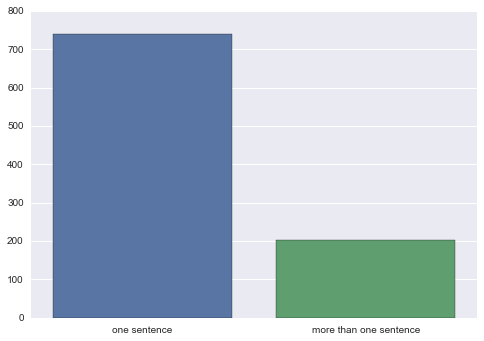

In [65]:
one = 0
more_than_one = 0
x = ['one sentence','more than one sentence']

for tweet in sentence_list:
    if len(tweet) <= 1:
        one += 1
    else:
        more_than_one += 1

y = [one,more_than_one]
sns.barplot(x=x, y=y)

#### Second – words. Which words appear the most in our tweets?

We already have a list of the tweeted words defined above with the Counter module, but let's see how we can also do it in NLTK.

In [66]:
#Import tokenize words module

from nltk.tokenize import word_tokenize

words_dict = {}

for text in tweets:
    words = word_tokenize(text)
    
    for word in words:
        if word not in words_dict:
            words_dict[word] = 1
        else:
            words_dict[word] += 1

In [67]:
#Now sort the values. Need to first import an Ordered Dictionary module, 
# becuase it's exceedingly annoying to order a regular python dictionary.

from collections import OrderedDict

ordered_words_dict = OrderedDict(sorted(words_dict.items(), reverse=True, key= lambda x: x[1]))

#Remove punctuation

punc = [':','.','#','@','-','$','(',',',')','``','\'\'']

for word in ordered_words_dict:
    if word in punc:
        ordered_words_dict.pop(word)

#Remove stopwords

for t in nltk.corpus.stopwords.words('english'):
    if t in ordered_words_dict:
        ordered_words_dict.pop(t)
        
ordered_words_dict

OrderedDict([('https', 876),
             ('Apple', 673),
             ('I', 493),
             ("'s", 324),
             ('RT', 228),
             ('u', 214),
             ('app', 198),
             ('iOS', 150),
             ('apple', 138),
             ('iPhone', 117),
             ('7', 113),
             ('called', 110),
             ('new', 91),
             ('fan', 87),
             ("'re", 86),
             ('saw', 82),
             ('!', 79),
             ('known', 78),
             ('?', 78),
             ('update', 73),
             ('training', 72),
             ('MyTraining', 70),
             ('mytraining', 68),
             ('ask', 65),
             ('The', 65),
             ('try', 59),
             ('lover', 57),
             ('never', 56),
             ('free', 56),
             ('could', 55),
             ('checked', 54),
             ('hey', 54),
             ('hi', 54),
             ('...', 53),
             ('suggest', 53),
             ('noticed', 53),
          

That was needlessly more hard than using Counter, but it shows how to use NLTK to do it.

#### Third – POS Tagging, or what seems to be the most popular usage of NLTK (if you look around the internet).

Let's see what the most common parts of speech are in our Apple tweets.

In [68]:
#Module already imported from text tokenize.

tags = {}

for text in tweets:
    words = word_tokenize(text)
    sentence_pos = nltk.pos_tag(words)
    
    for pos in sentence_pos:
        if pos[1] not in tags:
            tags[pos[1]] = 1
        else:
            tags[pos[1]] +=1
            
#And remove punctuation

punc = [':','.','#','@','-','$','(',',',')','``','\'\'']

for tag in tags.keys(): #Make sure to use .keys(), or you get a RunTime Error for changing the dict size
    if tag in punc:
        tags.pop(tag)

Let's graph the POS tags by frequency, and take a look at the definition of some of the most popular ones.

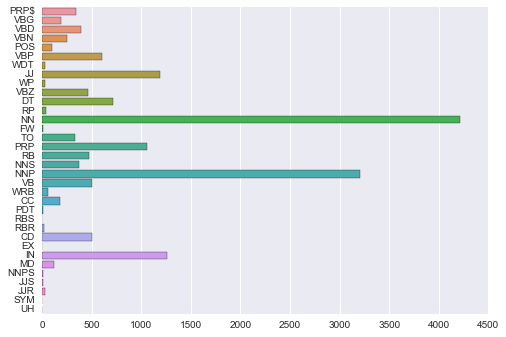

In [69]:
#Define our variables

y = tags.keys()
x = tags.values()

sns.barplot(x=x, y=y)

In [70]:
nltk.help.upenn_tagset('NN')

NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


In [71]:
nltk.help.upenn_tagset('NNP')

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...


In [72]:
nltk.help.upenn_tagset('JJ')

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...


In [73]:
nltk.help.upenn_tagset('IN')

IN: preposition or conjunction, subordinating
    astride among uppon whether out inside pro despite on by throughout
    below within for towards near behind atop around if like until below
    next into if beside ...


In [74]:
nltk.help.upenn_tagset('VBP')

VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...


Not surprising – nouns, adjectives, prepositions, and verbs are the most popular POS tags in our tweets.

### The big finale – creating a sentiment analyzer with TextBlob

The easiest way to analyze tweet sentiment without having to create a whole complicated classifier (and finding training data!) is using TextBlob's sentiment analysis tools.

In [116]:
from textblob import TextBlob

Before we do that though, we need to remove all of those spammy tweets we found above.

In [101]:
for key in tweets.keys():
    if '"mytraining"' in tweets[key]:
        tweets.drop(key)

Before we pass our tweets into TextBlob's sentiment function, we should clean them up and remove links and such.

In [109]:
#Import the regular expressions module – code borrowed from http://ravikiranj.net/posts/2012/code/how-build-twitter-sentiment-analyzer/

import re

def scrubTweet(tweet):
    
    #All lower case
    tweet = tweet.lower()
    
    #Remove links
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    #Convert @user to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    
    #Remove whitespace
    tweet = re.sub('[\s]+',' ',tweet)
    
    #Replace #hashtag with hashtag
    tweet = re.sub(r'#([^\s])+', r'\1', tweet)
    
    tweet.strip('\'"')
    
    return tweet

In [111]:
#Run the scrubber on our tweets

for tweet in tweets:
    scrubTweet(tweet)

Now we can run the sentiment function on each of our tweets and put the results in a dataframe.

In [119]:
sentiments = pd.DataFrame()

sentiments['tweet'] = tweets

In [120]:
polarities = []
subjectivities = []

for tweet in tweets:
    tweet_blob = TextBlob(tweet)
    
    polarity = tweet_blob.sentiment.polarity
    polarities.append(polarity)
    
    subjectivity = tweet_blob.sentiment.subjectivity
    subjectivities.append(subjectivity)
    
sentiments['polarity'] = polarities
sentiments['subjectivity'] = subjectivities

In [122]:
sentiments.describe()

,polarity,subjectivity
count,942.000000,942.000000
mean,0.123202,0.353010
std,0.265530,0.327273
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.400000
75%,0.250000,0.559754
max,1.000000,1.000000


And there is is! The average sentiment of the tweets we collected was .123 on a scale between -1 and 1. That's pretty close to neutral, so it's not terrible, but it's not great either.